## Hate Speech Recognition - DistilBert Fine-Tuning

#### Rapid advances in artificial intelligence (AI) have opened up a world of possibilities, empowering machines to identify offensive and hateful speech on online platforms and social media. With the increase in the spread of hateful and offensive speech on the internet, distinguishing between genuine and harmful expressions has become an increasingly complex task.

#### In this project, we delve into the fascinating field of detecting offensive and hate speech, where models like Distilbert, through fine-tuning, have emerged as powerful tools. By training a Distilbert model specifically designed to discern between normal and harmful speech, we can effectively identify and combat offensive messages on online platforms.

#### The objective of this project is to highlight Distilbert's potential in combating the growing wave of offensive and hate speech on the internet. By harnessing the power of natural language processing and machine learning, we can build systems capable of identifying and neutralizing harmful content, thereby preserving a safer and healthier online environment.

### Hate Speech Recognition using the following files:
* https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
* https://www.kaggle.com/datasets/grupomei30/hate-speech-and-offensive-language-dataset2

#### In total there are 27k comments from various platforms, belonging to one of the follow classes:
* neither
* offensive language
* hate speech

#### DistilBert Model:
* DistilBert-base-uncased

##### **Note**: The model used in this notebook was retrieved by the Hugging Face platform. For more info about the model: https://huggingface.co/distilbert-base-uncased

## Dependencies Instalation

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install transformers -U
!pip install --upgrade accelerate
!pip install --upgrade tensorflow
!pip install --upgrade transformers
!pip install livelossplot

## Imports

In [ ]:
import os
import re
import json
import gc
import logging
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from livelossplot import PlotLossesKerasTF
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments, TrainerCallback
from transformers.optimization import Adafactor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Notebook Parameters¶

In [ ]:
input_directory_dataset1 = "/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv"
input_directory_dataset2 = "/kaggle/input/hate-speech-and-offensive-language-dataset2/HateSpeechDetection.csv"
save_directory = "/kaggle/working/saved_models"

BATCH_SIZE_TRAIN=256
BATCH_SIZE_EVAL=100
EPOCHS=75

## Data Preparation and Treatment
* Dataset 1 treatment and visualization
* Dataset 2 treatment and visualization
* Merged (d1 + d2) dataset treatment and visualization

### Dataset 1
* One-cold encoding
* Cleaning all comments with regex expressions
* Droping unnecessary columns
* Renaming columns

In [5]:
df1 = pd.read_csv(input_directory_dataset1)
df1 = df1.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])

cat = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}

df1['label'] = df1['class'].map(cat)
df1 = df1.drop(columns=['class'])

df1['tweet'] = df1['tweet'].apply(lambda x: re.sub(r'(@\w+)', '', x))
df1['tweet'] = df1['tweet'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x))
df1['tweet'] = df1['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df1['tweet'] = df1['tweet'].apply(lambda x: x.replace('RT', '').lstrip())
df1['tweet'] = df1['tweet'].apply(lambda x: re.sub(r'[\t\n]+', ' ', x))
df1['tweet'] = df1['tweet'].apply(lambda x: re.sub('http\S+', '', x))
df1['tweet'] = df1['tweet'].apply(lambda x: re.sub(r'\b\d{10,}\b', '', x))
df1 = df1.rename(columns={'tweet' : 'text', 'label' : 'category'})

df1 = df1.rename(columns={'label': 'category', 'commentary' : 'text'})

df1.head()

,text,category
0,As a woman you shouldnt complain about cleanin...,neither
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,offensive language
2,Dawg You ever fuck a bitch and she start to ...,offensive language
3,she look like a tranny,offensive language
4,The shit you hear about me might be true or it...,offensive language


#### Data Visualization
* Ploting the dataset by classes

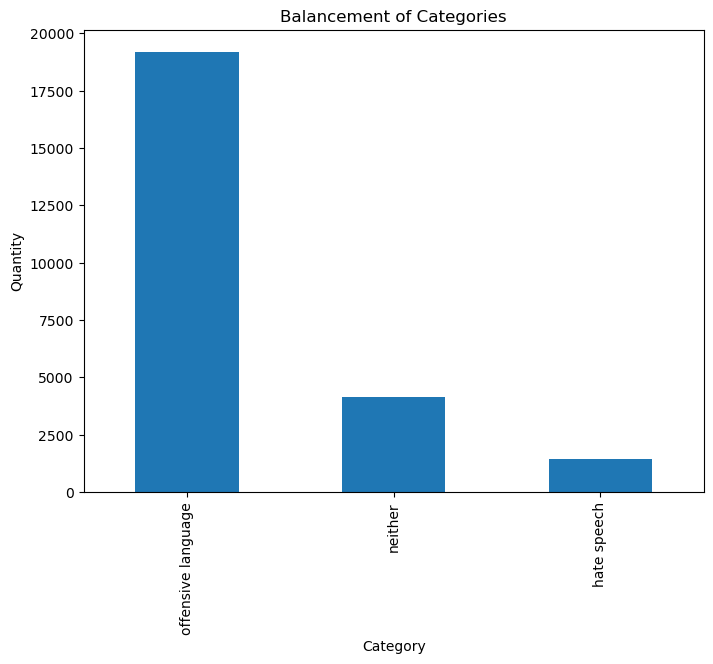

offensive language    19190
neither                4163
hate speech            1430
Name: category, dtype: int64


In [6]:
allcategories = df1['category'].value_counts()
plt.figure(figsize=(8, 6))
allcategories.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.title('Balancement of Categories')
plt.show()

print(df1['category'].value_counts())

### Dataset 2
* One-cold Encoding
* Droping unnecessary columns
* Renaming columns

In [7]:
df2 = pd.read_csv(input_directory_dataset2)
cat = {1: 'hate speech', 0: 'neither'}
df2['label'] = df2['Hateful'].map(cat)
df2 = df2.drop(columns=["Platform", "Hateful"])
df2 = df2.rename(columns={'label': 'category', 'Comment' : 'text'})
df2.head()

,text,category
0,Damn I thought they had strict gun laws in Ger...,neither
1,I dont care about what it stands for or anythi...,neither
2,It's not a group it's an idea lol,neither
3,So it's not just America!,neither
4,The dog is a spectacular dancer considering he...,neither


#### Data Visualization
* Ploting the dataset by classes

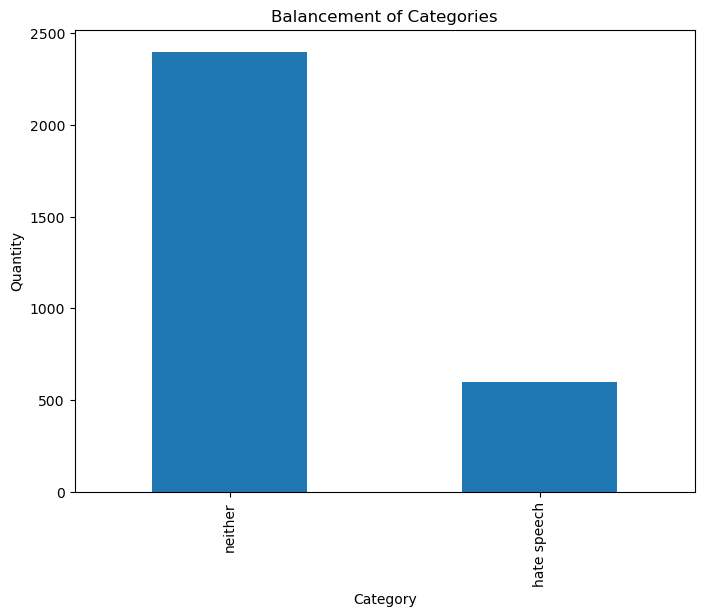

neither        2400
hate speech     600
Name: category, dtype: int64


In [8]:
allcategories = df2['category'].value_counts()
plt.figure(figsize=(8, 6))
allcategories.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.title('Balancement of Categories')
plt.show()

print(df2['category'].value_counts())

### Dataset 1 and Dataset 2
* One-hot encoding
* Merging datasets

In [9]:
df1['encoded_cat'] = df1['category'].astype('category').cat.codes
df2['encoded_cat'] = df2['category'].astype('category').cat.codes
df1.head()

,text,category,encoded_cat
0,As a woman you shouldnt complain about cleanin...,neither,1
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,offensive language,2
2,Dawg You ever fuck a bitch and she start to ...,offensive language,2
3,she look like a tranny,offensive language,2
4,The shit you hear about me might be true or it...,offensive language,2


In [10]:
df = pd.concat([df1, df2], ignore_index=True)

### Merged Dataset
* Balancing classes
* Comparing classes distributions
* Droping missing values in columns: **text** and **category**
* Puting to a respective list the values of the columns: **text** and **encoded_cat** 

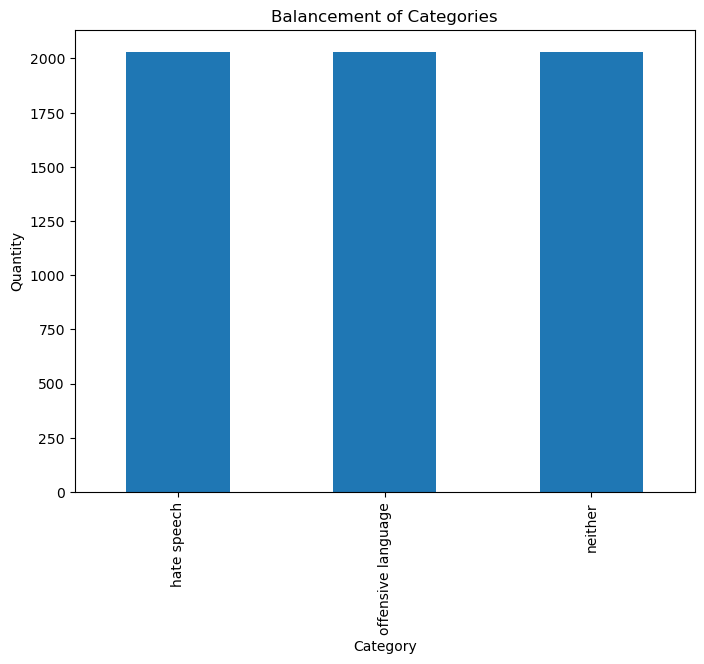

hate speech           2030
offensive language    2030
neither               2030
Name: category, dtype: int64


In [11]:
df = df.drop(df[df['category'] == 'offensive language'].index[:17160])
df = df.drop(df[df['category'] == 'neither'].index[:4533])

allcategories = df['category'].value_counts()
plt.figure(figsize=(8, 6))
allcategories.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.title('Balancement of Categories')
plt.show()

print(df['category'].value_counts())

In [12]:
df

,text,category,encoded_cat
85,queer gaywad,hate speech,0
89,alsarabsss hes a beaner smh you can tell hes a...,hate speech,0
110,youre fucking gay blacklisted hoe Holding out ...,hate speech,0
184,LMFAOOOO I HATE BLACK PEOPLE This is why ther...,hate speech,0
202,At least Im not a nigger Lmfao,hate speech,0
...,...,...,...
27778,This is what Kike shilling looks like. Ryan ha...,hate speech,0
27779,"Not bait, they're right",neither,1
27780,I like this one a lot.,neither,1
27781,Kikes making money off heroin what’s new,hate speech,0


In [13]:
df = df.dropna(subset=['category'])
df = df.dropna(subset=['text'])

In [14]:
data_texts = df["text"].to_list() 
data_labels = df["encoded_cat"].to_list()

## Data Split
* Training data = 72%
* Validation data = 20%
* Test data = 8%

In [57]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=2023)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=0)

## Tokenizing Data

In [58]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [75]:
MAX_SEQUENCE_LENGTH = len(train_encodings['input_ids'][0])
NUM_LABELS = len(df["category"].unique())
id2label = {0 : 'hate speech', 1 : 'neither', 2 : 'offensive language'}
id2label

{0: 'hate speech', 1: 'neither', 2: 'offensive language'}

## Making a dataset with the tokens in a dictionary from every text to the respective label
* Traing set
* Validation set

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

## Distilbert-base-uncased Model
* Getting the model
* Compiling the model

In [76]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=NUM_LABELS)

optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-7)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Model Summary

In [77]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_261 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the Model

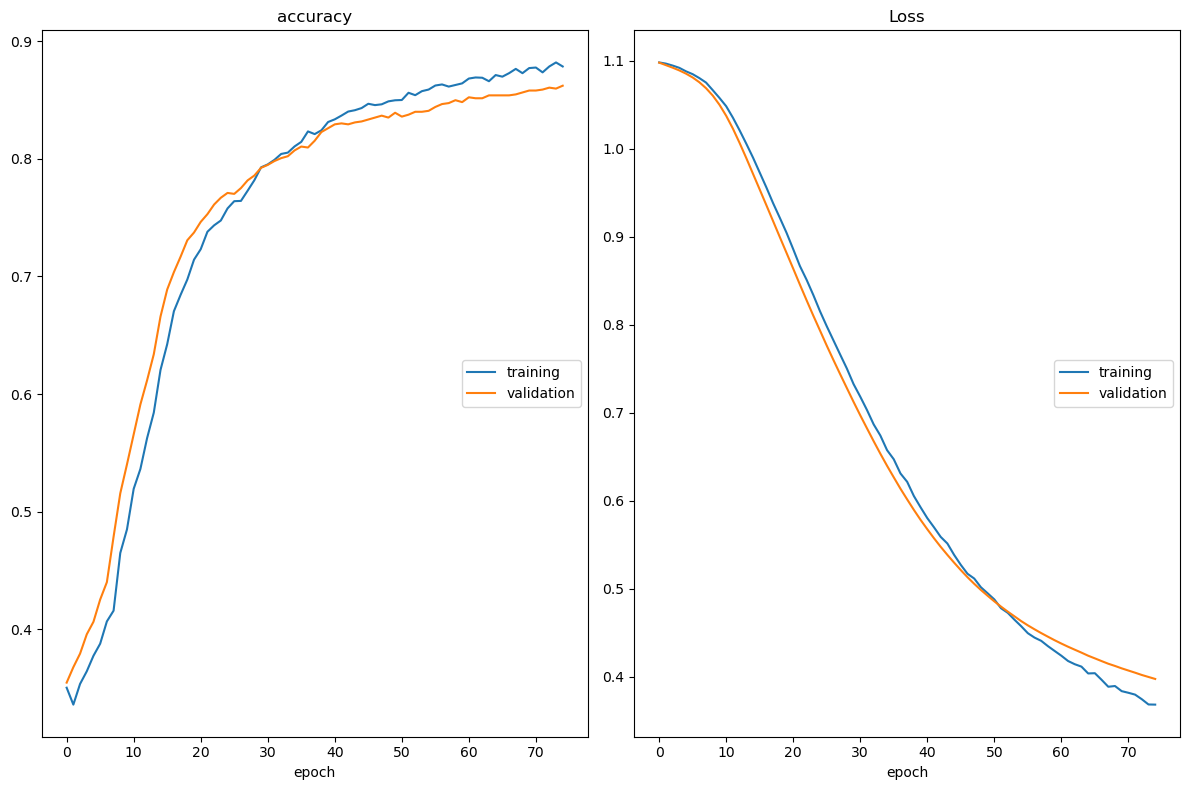

accuracy
	training         	 (min:    0.336, max:    0.882, cur:    0.878)
	validation       	 (min:    0.355, max:    0.862, cur:    0.862)
Loss
	training         	 (min:    0.368, max:    1.098, cur:    0.368)
	validation       	 (min:    0.398, max:    1.098, cur:    0.398)
18/18 [==============================] - 17s 924ms/step - loss: 0.3684 - accuracy: 0.8784 - val_loss: 0.3976 - val_accuracy: 0.8621


In [78]:
history = model.fit(train_dataset.shuffle(1000).batch(BATCH_SIZE_TRAIN), epochs=EPOCHS, batch_size=BATCH_SIZE_TRAIN,
          validation_data=val_dataset.shuffle(1000).batch(BATCH_SIZE_EVAL), callbacks=[PlotLossesKerasTF()], verbose=1)

## Evaluate the Model
* Precision
* Recall
* F1-score
* Accuracy

In [79]:
test_text_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_text_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_text_encodings),
    test_labels
))

predictions = model.predict(test_text_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1)

print("Accuracy: ", accuracy_score(test_labels, predicted_labels))
print("Model Fine-Tuned DistilBert: \n", classification_report(test_labels, predicted_labels))

488/488 [==============================] - 5s 7ms/step
Accuracy:  0.8319672131147541
Model Fine-Tuned DistilBert: 
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       185
           1       0.91      0.93      0.92       163
           2       0.77      0.81      0.79       140

    accuracy                           0.83       488
   macro avg       0.83      0.83      0.83       488
weighted avg       0.83      0.83      0.83       488



## Tests

### Classification of a given commentary

In [ ]:
tf.config.run_functions_eagerly(True)

predict_input = tokenizer.encode("Living his best life while his supposed friend struggles every day bc of his dumb fanatics ",
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
output = trainer_model(predict_input)[0]
print(output)

prediction_value = id2label[tf.argmax(output, axis=1).numpy()[0]]
prediction_value

## Saving the Model

In [ ]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

## Loading the Model

In [ ]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

## Testing the loaded model

In [ ]:
predict_input = loaded_tokenizer.encode("Just a normal beautiful day",
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = id2label[tf.argmax(output, axis=1).numpy()[0]]
prediction_value